In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import geopandas as gpd
from geopy.geocoders import Nominatim
import time
from shapely.geometry import Point
import geodatasets


# Reading Data

This dataset contains information about **used cars** listed for sale, including their key specifications, usage, and prices. Each row represents a single car entry, and the columns capture attributes such as brand, model, year of manufacture, mileage (in kilometers run), and selling price. Additional variables may include fuel type, transmission type, number of owners, and location.

In [3]:
cars = pd.read_csv("Used_Car_Price_Prediction.csv")
cars.head(10)

,car_name,yr_mfr,fuel_type,kms_run,sale_price,city,times_viewed,body_type,transmission,variant,...,total_owners,broker_quote,original_price,car_rating,ad_created_on,fitness_certificate,emi_starts_from,booking_down_pymnt,reserved,warranty_avail
0,maruti swift,2015,petrol,8063,386399,noida,18715,hatchback,manual,lxi opt,...,2,397677,404177.0,great,2021-04-04T07:09:18.583,True,8975,57960,False,False
1,maruti alto 800,2016,petrol,23104,265499,noida,2676,hatchback,manual,lxi,...,1,272935,354313.0,great,2021-03-22T14:07:32.833,True,6167,39825,False,False
2,hyundai grand i10,2017,petrol,23402,477699,noida,609,hatchback,manual,sports 1.2 vtvt,...,1,469605,NaN,great,2021-03-20T05:36:31.311,True,11096,71655,False,False
3,maruti swift,2013,diesel,39124,307999,noida,6511,hatchback,manual,vdi,...,1,294262,374326.0,great,2021-01-21T12:59:19.299,True,7154,46200,False,False
4,hyundai grand i10,2015,petrol,22116,361499,noida,3225,hatchback,manual,magna 1.2 vtvt,...,1,360716,367216.0,great,2021-04-01T13:33:40.733,True,8397,54225,False,False
5,maruti alto k10,2018,petrol,23534,335299,noida,1055,hatchback,NaN,vxi (o) amt,...,1,343212,439056.0,great,2021-04-13T05:55:16.99,True,7788,50295,False,False
6,maruti ritz,2012,diesel,41213,281999,noida,909,hatchback,manual,vdi,...,1,201200,NaN,great,2020-12-29T07:26:25.321,True,6550,42300,False,False
7,hyundai i20,2012,petrol,38328,321499,noida,2760,hatchback,manual,asta 1.2,...,3,319200,410764.0,great,2021-02-25T15:47:30.3,True,7468,48225,False,False
8,hyundai elite i20,2014,diesel,56402,456199,noida,2475,hatchback,manual,magna 1.4 crdi,...,1,452023,566123.0,great,2021-03-13T11:57:25.71,True,10596,68430,False,False
9,renault kwid,2018,petrol,32703,281299,noida,2497,hatchback,manual,rxl,...,1,264597,344127.0,great,2021-03-20T06:52:56.488,True,6534,42195,False,False


# Missing-Value Imputation


The following two code cells handle the missing data in **original price** column using KNN, and **transmission** column using data replacement.

In [4]:
imputer = KNNImputer(n_neighbors=5, weights='distance')
cars['original_price'] = imputer.fit_transform(cars[['original_price']])

In [5]:
cars['transmission'] = cars['transmission'].fillna('unknown')

# Creating New Columns

In [6]:
# add the column car_age
cars['car_age'] = (2021 - cars['yr_mfr']).fillna(np.nan)

In [7]:
#Check if it is created:
cars[['yr_mfr', 'car_age']].head()

,yr_mfr,car_age
0,2015,6
1,2016,5
2,2017,4
3,2013,8
4,2015,6


In [8]:
# Create a column to indicate car usage per year
cars['usage_per_year'] = cars['kms_run'] / (cars['car_age'].replace(0, np.nan))
def usage_category(usage):
    if pd.isna(usage):
        return np.nan
    elif usage < 10000:
        return 'Light'
    elif usage < 20000:
        return 'Fair'
    else:
        return 'Heavy'

cars['usage_category'] = cars['usage_per_year'].apply(usage_category)


In [9]:
#Check if usage_category was added :
cars[['car_age', 'kms_run', 'usage_per_year', 'usage_category']].head()

,car_age,kms_run,usage_per_year,usage_category
0,6,8063,1343.833333,Light
1,5,23104,4620.800000,Light
2,4,23402,5850.500000,Light
3,8,39124,4890.500000,Light
4,6,22116,3686.000000,Light


In [10]:
cars.groupby('usage_category').size()

usage_category
Fair     2176
Heavy     428
Light    4794
dtype: int64

# Visualizations

### *Relationship Between Sale Price and Key Vehicle Features*

 #### **Sale Price Vs Fuel Type, Transmission, and Body Type**  

The following boxplots illustrate how **sale prices vary across different vehicle characteristics** — specifically, **Fuel Type**, **Transmission**, and **Body Type**.  
Each box represents the distribution of prices within a category, allowing us to compare median values, price spreads, and the presence of outliers.  
By examining these plots, we can better understand which attributes tend to command higher market prices and which categories generally fall into lower price ranges.

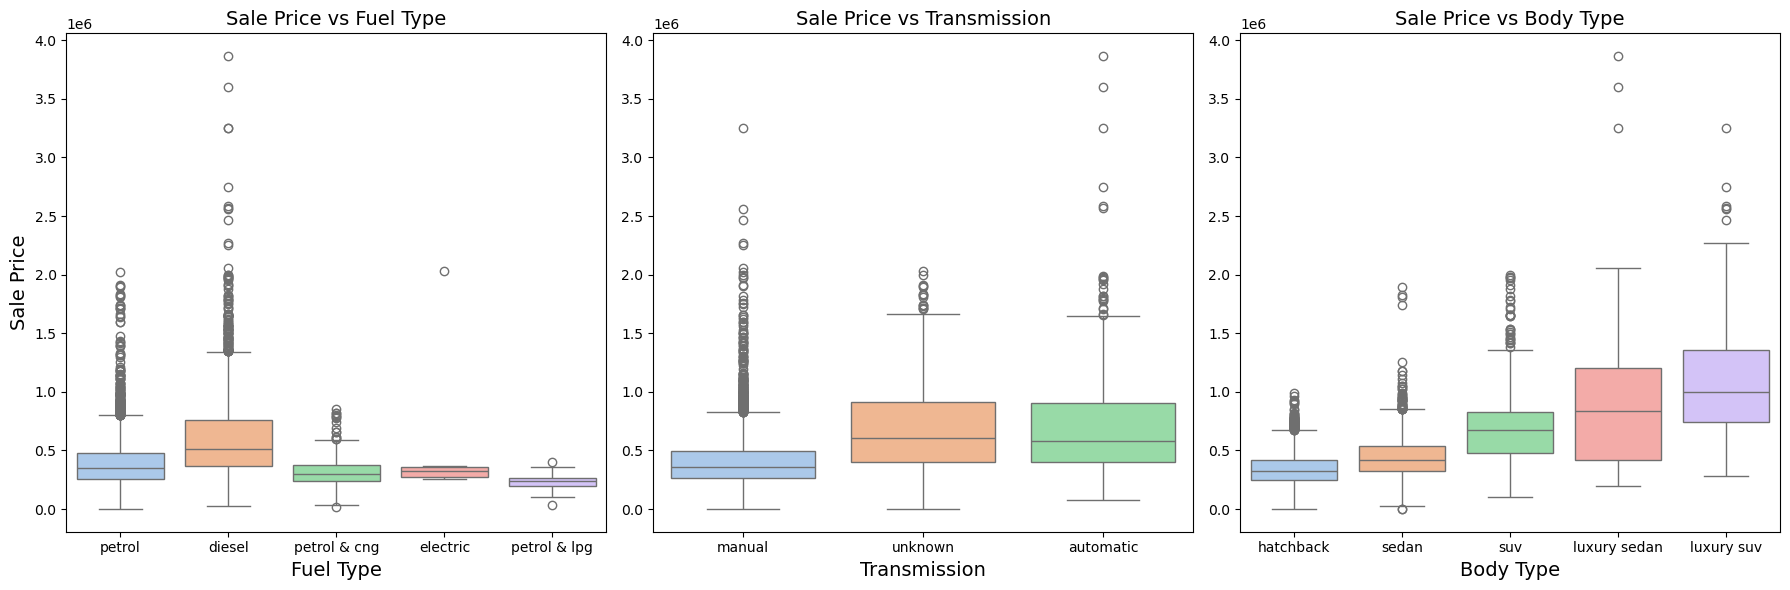

In [11]:
# Set up the figure with subplots for each categorical variable
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot: sale_price vs fuel_type
sns.boxplot(x='fuel_type', y='sale_price', data=cars, ax=axes[0],
            hue='fuel_type', palette='pastel', legend=False)
axes[0].set_title('Sale Price vs Fuel Type', fontsize=14)
axes[0].set_xlabel('Fuel Type', fontsize=14)
axes[0].set_ylabel('Sale Price', fontsize=14)

# Boxplot: sale_price vs transmission
sns.boxplot(x='transmission', y='sale_price', data=cars, ax=axes[1],
           hue='transmission', palette='pastel', legend=False)
axes[1].set_title('Sale Price vs Transmission', fontsize=14)
axes[1].set_xlabel('Transmission', fontsize=14)
axes[1].set_ylabel('')

# Boxplot: sale_price vs body_type
sns.boxplot(x='body_type', y='sale_price', data=cars, ax=axes[2],
           hue='body_type', palette='pastel', legend=False)
axes[2].set_title('Sale Price vs Body Type', fontsize=14)
axes[2].set_xlabel('Body Type', fontsize=14)
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

In [12]:
cars.groupby('transmission')['sale_price'].median().sort_values(ascending=False)

transmission
unknown      604199.0
automatic    581699.0
manual       360000.0
Name: sale_price, dtype: float64

In [13]:
cars.groupby('body_type')['sale_price'].median().sort_values(ascending=False)

body_type
luxury suv      1000000.0
luxury sedan     835699.0
suv              671699.0
sedan            414499.0
hatchback        322699.0
Name: sale_price, dtype: float64

In [14]:
cars.groupby('fuel_type')['sale_price'].median().sort_values(ascending=False)

fuel_type
diesel          515199.0
petrol          350599.0
electric        327099.5
petrol & cng    302099.0
petrol & lpg    238599.0
Name: sale_price, dtype: float64

#### Insights from the Distribution

- **Fuel Type:**  
  Diesel vehicles show the highest median sale price, standing well above petrol.  
  Electric cars follow closely, suggesting they are gaining value but are still priced below diesel models, likely due to smaller sample sizes or more compact segments.  
  Dual-fuel cars (Petrol & CNG/LPG) consistently have the lowest prices, reflecting their budget-friendly market positioning.

- **Transmission:**  
  Neglecting the **“unknown”** transmission type graph, **automatic** vehicles are clearly more expensive than **manual** ones, reinforcing consumer preference for comfort and higher-end variants.

- **Body Type:**  
  The price hierarchy is quite clear — **Luxury SUVs** and **Luxury Sedans** dominate the upper segment, followed by **SUVs**, **Sedans** , and **Hatchbacks**.  
  This gradient mirrors typical market valuation patterns based on size, comfort, and brand positioning.

Overall, the analysis shows a **strong correlation between vehicle type, powertrain, and price**.  
Luxury and diesel-powered cars retain higher value, while compact, dual-fuel, or manual-transmission vehicles tend to occupy the lower end of the market.

#### **Sale Price Vs Year of Manufacture depending on Fuel Type**

Scatter plot with Trendline : The following visualization examines how **car sale prices change with manufacturing year** across different **fuel types**.  
Each point represents an individual vehicle listing, colored according to its fuel category, while the trendlines highlight **depreciation behavior over time** for each type.  
This view helps reveal which technologies hold their value better in the used-car market, and how quickly prices drop as vehicles age.


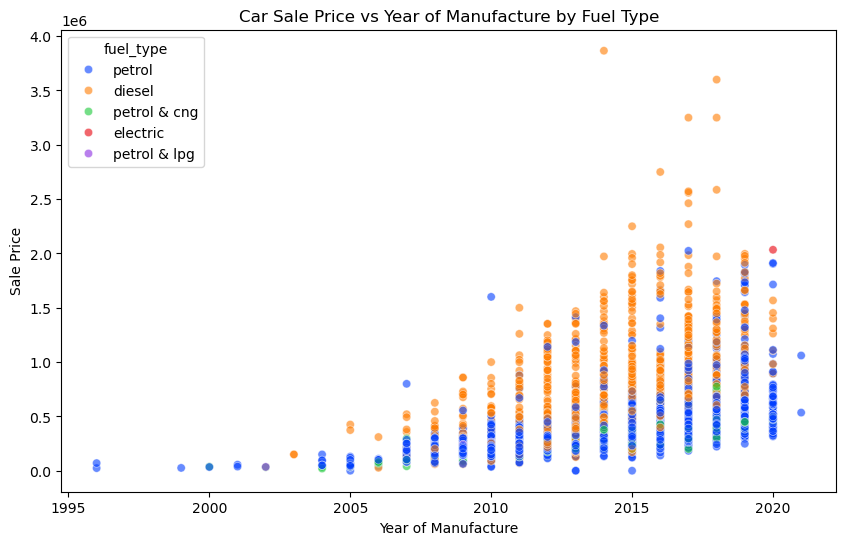

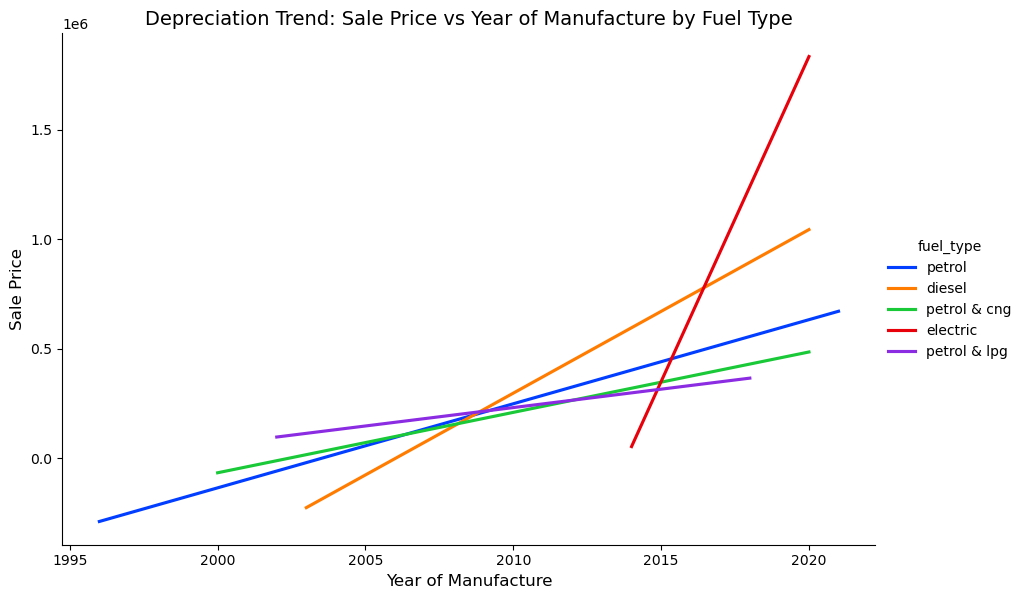

In [15]:
# Scatter layer: each point is a car, colored by fuel type
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cars, x='yr_mfr', y='sale_price',
    hue='fuel_type', alpha=0.6, palette='bright')

# Scatter Plot Titles and labels
plt.title('Car Sale Price vs Year of Manufacture by Fuel Type')
plt.xlabel('Year of Manufacture')
plt.ylabel('Sale Price')

# Add trendlines (regression lines) per fuel type
sns.lmplot(data=cars, x='yr_mfr', y='sale_price',
    hue='fuel_type', scatter=False, aspect=1.5, height=6,
    ci=None, palette='bright')

# Trendlines Titles and labels
plt.title('Depreciation Trend: Sale Price vs Year of Manufacture by Fuel Type', fontsize=14)
plt.xlabel('Year of Manufacture', fontsize=12)
plt.ylabel('Sale Price', fontsize=12)
plt.show()

#### Insights from the Depreciation Trends

- **Overall Trend:**  
  As expected, sale price generally increases with the year of manufacture — newer cars command higher resale values, while older models show a steady decline in price.

- **Fuel Type Evolution:**  
  - **Before 2005**, cars running on **Petrol & CNG/LPG** show surprisingly higher sale prices than petrol or diesel vehicles. This may reflect the limited number of CNG/LPG models at that time — often newer, city-focused vehicles — rather than a true market premium.  
  - **Diesel vehicles** dominate most of the mid-range years (2005–2018), holding relatively high resale values due to their efficiency and popularity in larger body types (SUVs, sedans).  
  - **Electric vehicles** show a steep upward trend in recent years, with rapidly increasing prices for newer models, reflecting technological improvements and a growing shift toward EV adoption.  
  - **Petrol cars** follow a smoother depreciation curve, consistently below diesel, aligning with their broader availability and lower initial cost.

- **Market Interpretation:**  
  The plot highlights how **fuel technology and production era interact** to shape vehicle pricing trends.  
  Early-generation CNG/LPG vehicles once occupied a higher price range due to scarcity, while modern market dynamics favor **electric and diesel models** with better efficiency and perceived long-term value.

#### **Sale price versus Km run densitity**  
This hexbin plot visualizes the relationship between **kilometers driven** and **sale price** for all cars in the dataset.  
Each hexagonal cell represents a group of cars with similar mileage and price values, and the color intensity (on a logarithmic scale) indicates how many cars fall into that range.  
Using a hexbin map instead of a scatter plot helps reveal overall trends and data density, even when there are thousands of overlapping points.


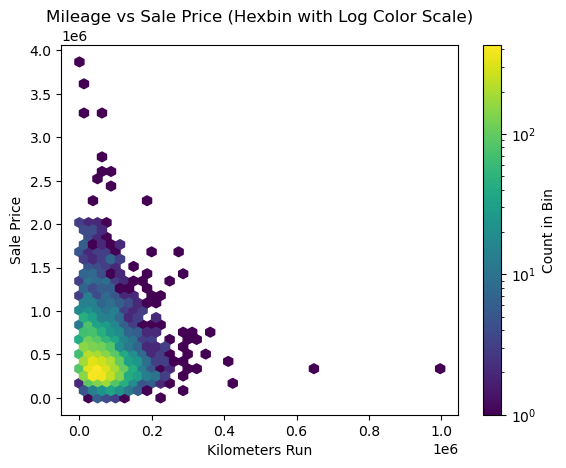

In [16]:
plt.hexbin(cars['kms_run'], cars['sale_price'],
            gridsize=40, cmap='viridis', norm=LogNorm())
plt.xlabel('Kilometers Run')
plt.ylabel('Sale Price')
plt.title('Mileage vs Sale Price (Hexbin with Log Color Scale)')
plt.colorbar(label='Count in Bin')
plt.show()

#### Insights from the Mileage–Price Distribution

- **General Pattern:**  
  There is a clear **negative relationship** between mileage and sale price — cars with higher kilometers run tend to sell for less.  
  The densest region appears at **moderate mileage levels** (roughly 30,000–80,000 km) and **mid-range prices**, suggesting this is the most common segment of the market.

- **Low-Mileage Vehicles:**  
  Cars with very low mileage cluster at the higher end of sale prices, reflecting their better condition and lower wear.

- **High-Mileage Vehicles:**  
  As mileage increases, prices drop sharply, and listings become less dense — indicating fewer buyers and lower valuation for heavily used cars.

- **Data Distribution:**  
  The logarithmic color scale highlights a heavy concentration of listings in the **lower-price, mid-mileage range**, with fewer listings at the extremes.  
  This suggests that while low-mileage cars command a premium, the bulk of the used-car market centers around moderately used vehicles.

Overall, the plot confirms that **vehicle usage is one of the strongest factors influencing price**, and most used-car transactions occur in the practical mid-range of mileage and value.

### *Count of ads over time (monthly)*

The following line plot shows the **monthly count of car advertisements** based on their creation dates.  
Each point represents the total number of ads posted in that month, allowing us to observe overall trends in listing activity.  
Tracking ad frequency over time can reveal seasonal effects, market slowdowns, or bursts of seller activity related to broader economic or policy factors.

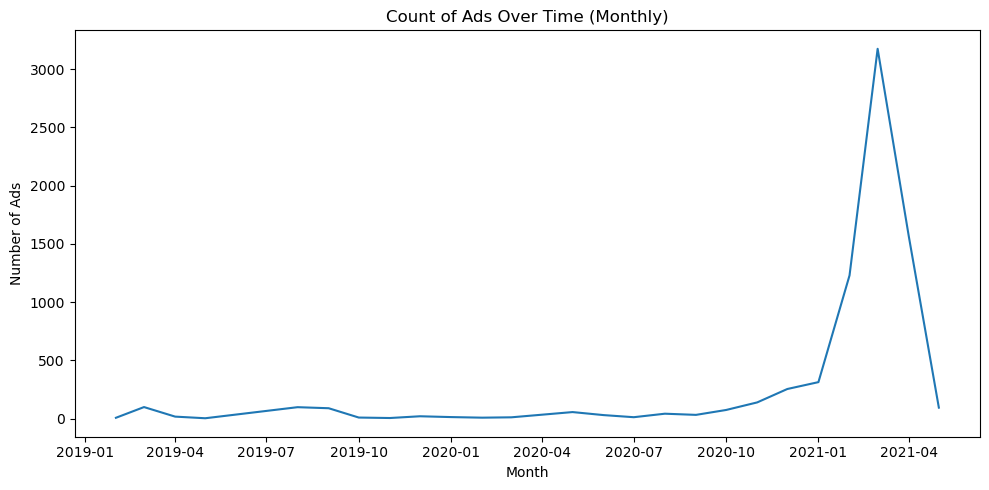

In [17]:

# Parse dates
df_time = cars[['ad_created_on']].copy()
df_time['ad_created_on'] = pd.to_datetime(df_time['ad_created_on'], errors='coerce')
df_time = df_time.dropna(subset=['ad_created_on'])

# Monthly counts
df_time['month'] = df_time['ad_created_on'].dt.to_period('M').dt.to_timestamp()
count_over_time = df_time.groupby('month').size().rename('num_ads')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(count_over_time.index, count_over_time.values)
plt.xlabel("Month")
plt.ylabel("Number of Ads")
plt.title("Count of Ads Over Time (Monthly)")
plt.tight_layout()
plt.show()

#### Insights from the Monthly Listing Trend

- **Overall Activity:**  
  The number of ads fluctuates over time, indicating varying levels of seller participation in the market.  
  Peaks may correspond to high-selling seasons or months with stronger demand for vehicle exchanges, while dips could reflect market slowdowns or off-peak periods.

- **Market Dynamics:**  
  Sustained upward trends over consecutive months could suggest a growing supply of used cars entering the market, while downward trends may indicate either improved sales turnover or reduced seller activity.

Overall, this visualization provides a clear overview of **market activity over time**, highlighting when sellers are most active and offering context for interpreting other pricing and demand patterns in the dataset.

The peak might be related to the market re-opening after the **COVID-19** lockdown.

### *Average sale price over time (monthly)*

In [18]:
cars['ad_created_on'] = pd.to_datetime(cars['ad_created_on'], errors='coerce')
cars['sale_price'] = pd.to_numeric(
    cars['sale_price'].astype(str).str.replace(r"[^\d.]", "", regex=True),
    errors='coerce'
)

# Drop missing values
df_time = cars.dropna(subset=['ad_created_on', 'sale_price']).copy()

# Extract month (as first day of that month for plotting)
df_time['month'] = df_time['ad_created_on'].dt.to_period('M').dt.to_timestamp()

# Group by month and take mean (average sale price per month)
avg_price_over_time = (
    df_time.groupby('month')['sale_price']
    .mean()
    .rename('avg_sale_price')
)

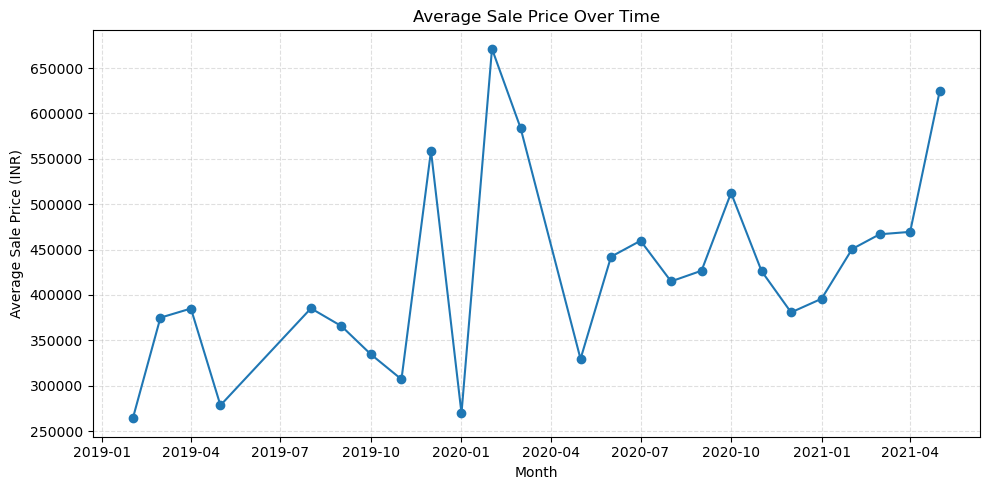

In [19]:
plt.figure(figsize=(10,5))
plt.plot(avg_price_over_time.index, avg_price_over_time.values, marker='o')
plt.xlabel('Month')
plt.ylabel('Average Sale Price (INR)')
plt.title('Average Sale Price Over Time')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

#### Insights from the Average Price Trend

- **Overall Pattern:**  
  The average sale price varies noticeably over time, reflecting changing market conditions, consumer demand, and the mix of vehicles being listed.

- **Rising or Declining Phases:**  
  Periods of price increase likely indicate higher-value vehicles entering the market (such as newer or luxury models), while downward phases may correspond to an influx of older or budget-friendly listings.

- **Stability Points:**  
  Months where the average sale price remains relatively stable suggest a balanced market, where supply and demand are consistent.


- **Interpretation:**  
  This trend can be influenced by several factors — such as fuel price changes, festive or tax seasons, or shifts in buyer preference toward electric and hybrid models.  
  Overall, the chart gives a clear picture of **how market pricing levels have evolved over time**, serving as a valuable indicator of general affordability and seller behavior in the used-car market.

### *Times viewed vs Sale price*


This scatter plot examines how the **number of times a vehicle ad was viewed** relates to its **sale price**.  
Each point represents a single car listing, showing whether more expensive cars attract more attention or whether buyers are more engaged with affordable options.  
This relationship helps evaluate how price influences consumer interest in online car listings.

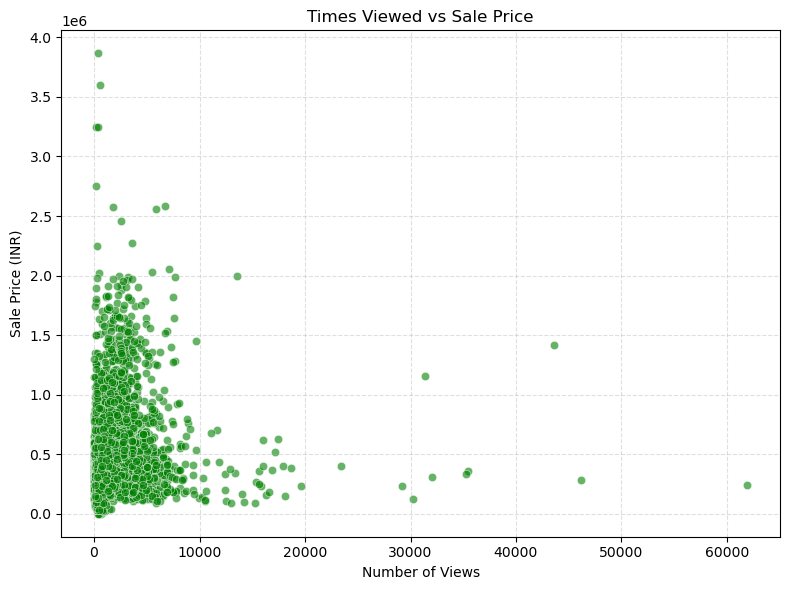

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=cars,
    x='times_viewed',
    y='sale_price',
    alpha=0.6,
    color='green'
)

plt.title('Times Viewed vs Sale Price')
plt.xlabel('Number of Views')
plt.ylabel('Sale Price (INR)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


#### Insights from number of views vs sales price
- There is no strong correlation between price and views — both low and high-priced cars attract attention.  
- Lower-priced cars generally receive more views, likely due to broader affordability.  
- Higher-priced listings get fewer but more focused views, reflecting niche buyer interest.  
Overall, viewing activity is influenced by more than just price, including brand and vehicle type.

### *Average Views by Fuel Type*

This bar chart compares the **average number of times listings were viewed** for each **fuel type**.  
It helps identify which fuel technologies generate the most buyer interest in the used-car market.

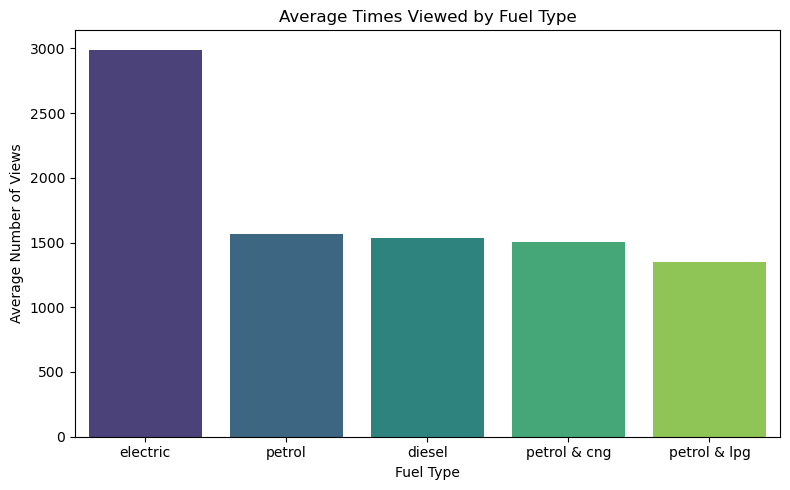

fuel_type
electric        2989.666667
petrol          1563.965873
diesel          1532.177171
petrol & cng    1503.602353
petrol & lpg    1347.048780
Name: times_viewed, dtype: float64

In [21]:
# Ensure numeric conversion
cars['times_viewed'] = pd.to_numeric(cars['times_viewed'], errors='coerce')

# Group by fuel type and calculate average views
avg_views_by_fuel = (
    cars.groupby('fuel_type')['times_viewed']
    .mean()
    .sort_values(ascending=False)
)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    x=avg_views_by_fuel.index,
    y=avg_views_by_fuel.values,
    hue=avg_views_by_fuel.index,   # assign hue to x variable
    palette='viridis',
    legend=False                   # remove unnecessary legend
)
plt.title('Average Times Viewed by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Average Number of Views')
plt.tight_layout()
plt.show()
avg_views_by_fuel


#### Insights from Average times viewed for each fuel type


- **Electric cars receive by far the most views**, almost **double** the attention of any other fuel type in the dataset.
- Among conventional fuels, **petrol**, **diesel**, and **petrol & CNG** attract very similar levels of interest.
- **Petrol & LPG cars** receive the lowest average views, but still show substantial engagement.
- Overall, the data indicates that **electric vehicles generate the strongest buyer interest**, while traditional fuel types cluster closely together with moderate but consistent viewership.

## *Top 15 Brands by Average Views*

This plot shows the top 15 brands with the highest average number of views per listing.  
It highlights which manufacturers attract the most buyer attention in the used-car market.

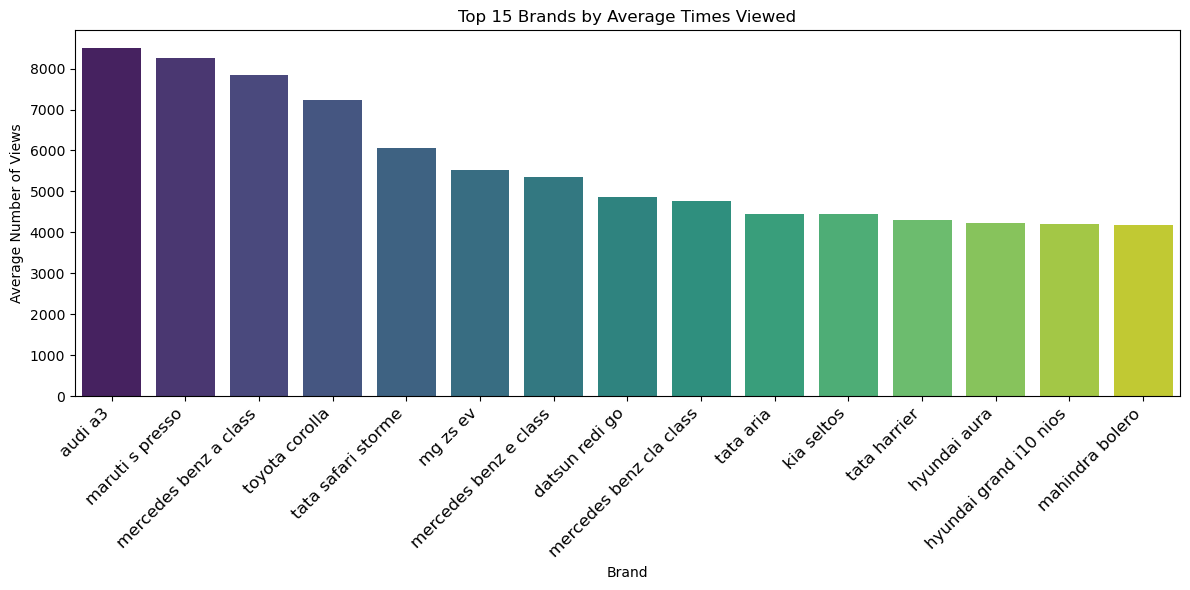

In [25]:
# Ensure times_viewed is numeric
cars['times_viewed'] = pd.to_numeric(cars['times_viewed'], errors='coerce')

# Group by brand (or 'manufacturer' if that’s your column)
avg_views_by_brand = (
    cars.groupby('car_name')['times_viewed']
    .mean()
    .sort_values(ascending=False)
)
top15_brands = avg_views_by_brand.head(15)
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top15_brands.index,
    y=top15_brands.values,
    hue=top15_brands.index,   # fixes the seaborn palette warning
    palette='viridis',
    legend=False
)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.title('Top 15 Brands by Average Times Viewed')
plt.xlabel('Brand')
plt.ylabel('Average Number of Views')
plt.tight_layout()
plt.show()

### Insights from most viewed brands

- The top-viewed brands clearly stand out, receiving significantly more buyer attention than the others.
- Several well-known manufacturers dominate the upper end of the ranking, suggesting strong market demand.
- Lower-ranked brands within the top 15 still perform well compared to the rest of the dataset.

### *Relationship between Location and Key Features*

The following visualizations explore how different variables related to car sales are affected by the city the car was sold in. Specifically, we are exploring what brands are most common in which city, the cities where cars with the highest amount of kilometers run are sold, sale prices for different brands in different cities, and which cities tend to prefer different transmission/fuel types. Additionally, we have included an interactive map showing the top 5 car brands in each city.

First, we will **create a Pandas GeoData frame** so we can make map plots, and we start by geocoding each of the cities in the dataframe.

In [39]:
# Geocode city names
geolocator = Nominatim(user_agent="city_mapper")
def geocode_city(city, country="India"):
  location = geolocator.geocode(f"{city}, {country}")
  if location:
    return location.latitude, location.longitude
  else:
    return None, None

cities = pd.DataFrame(cars["city"].astype('str').str.title().unique(), columns=["city"])
for city in cities["city"]:
    cities["lat"], cities["lon"] = geocode_city(city)  # your retry-safe function
    time.sleep(1)  # mandatory delay

Now, we can create a GeoDataFrame that includes latitude and longitude information for each city.

In [40]:
# Create GeoData Frame
cars["city"] = cars["city"].astype("str").str.title()
df = pd.merge(cars, cities, how="outer", on="city")
geometry = [Point(xy) for xy in zip(df["lon"], df["lat"])]
map_cars = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

Now, we can load in a basic map of India to put our plots over.

In [41]:
# Load basic map of India
#world = gpd.read_file(get_path("naturalearth_lowres"))
#print(world.head())
#TODO: Find map of the world that can be imported with python
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [42]:
#TODO: Create map plot that includes the top 5 car brands in each city

In [43]:
#TODO: Possibly add additional map showing highest average sale price, most popular transmission type, or other factors.

TODO: add insights from map(s)

### Distribution of Brands in Each City

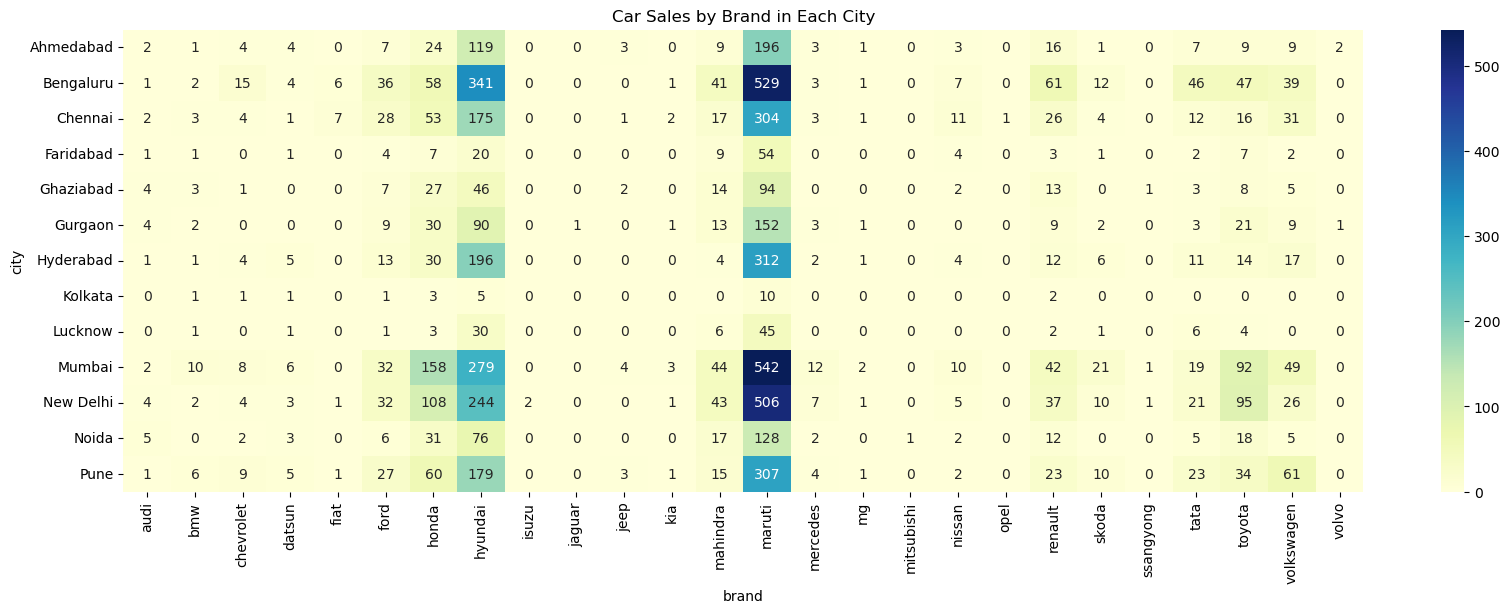

In [ ]:
# City vs. brand name
df["brand"] = df["car_name"].astype("str").str.split(" ").str[0]
popular_brands = df.groupby(["city", "lon", "lat", "brand"]).size().reset_index(name="count")
popular_brands = popular_brands.pivot(index="city", columns="brand", values="count").fillna(0)

plt.figure(figsize=(20, 6))
sns.heatmap(popular_brands, annot=True, fmt=".0f", cmap="YlGnBu");
plt.title("Car Sales by Brand in Each City");

This heatmap examines how the **number of cars sold** relates to **location** and **brand**. In other words, it shows the amount of listings from each brand in each city. 
Each square represents the intersection between city and brand, showing the total number of car listings.  
This plot shows us the popularity of each brand in each location, as well as giving us a good idea of the total number of listings there.

From this plot, it is clear that Maruti is the most popular brand overall, as well as the most popular in nearly every city. Other popular brands include Hyundai, Honda, Toyota and Volkswagen.

### *Distribution of Kilometers Run for Cars Listed in Each City*

<Axes: xlabel='kms_run', ylabel='city'>

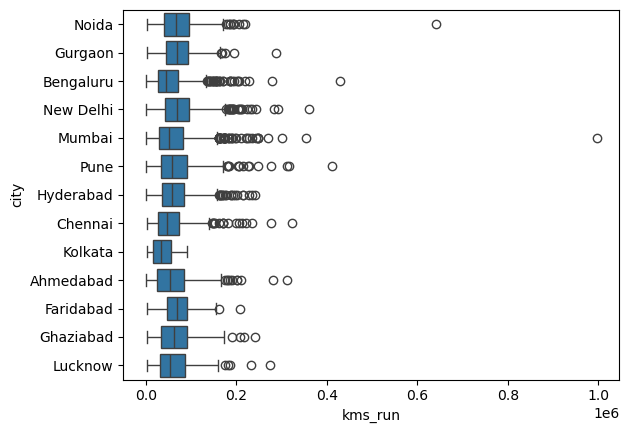

In [ ]:
# City vs. average kilometers run
sns.boxplot(x="kms_run", y="city", data=cars)

This plot shows the distribution of kilmeters run for each city, considering every listing in every city. To fully understand this plot, we must calculate the total number of listings. That way, we can observe whether what we see here is the result of **cars with higher amounts of kilometers run are listed** in certain cities, or if certain cities have **more cars listed**.

In [ ]:
#TODO: find the count of total listings for each city to fully interpret this plot.

In [ ]:
#TODO: City vs. sale price for each car type

In [ ]:
#TODO: City vs transmission and fuel type